# Imaging
To run this notebook first download `imaging_preprocessed_traces.h5` from [Zenodo](https://doi.org/10.5281/zenodo.5550454) and place it in the `data/processed` folder.

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from osn.bulb import imaging
from osn.preprocess import get_data_folders
from osn.viz import bulb_viz

In [3]:
sns.set_context("notebook")
sns.set(font_scale=1.5, style="ticks", palette="tab10")

# load imaging traces 

`imaging_preprocessed_traces.h5` contains the following hierarchy:
```
/data is a Group
/data/traces is a Group
/data/traces/5 is a Dataset of shape (17, 56, 72, 3001)
/data/traces/6 is a Dataset of shape (17, 48, 63, 3001)
/data/x is a Dataset of shape (3001,)
/metadata is a Group
/odors is an object Dataset
```

The traces are shape `odors x trials x glomeruli x timepoints`.
They are downsampled to 50 Hz and aligned to the population mean, as described in the methods. The timepoints in x match those in the traces, and the population mean onset is at 0.

In [4]:
# load the session and env for each trial
df_meta, env_mapping = imaging.load_df_meta()
# number of trials per mouse
print(df_meta.reset_index().groupby(['mouse']).trial_num.count())
df_meta.head()

mouse
5    56
6    48
Name: trial_num, dtype: int64


session  trial_num        env
mouse trial                                 
5     0      20210831a          0  home-cage
      1      20210831a          1  home-cage
      2      20210831a          2  home-cage
      3      20210831a          3  home-cage
      4      20210831a          4  home-cage

In [5]:
ODORS = imaging.load_key(key="odors")
print(ODORS)

# timepoints
x = imaging.load_key("data/x")
print(x.shape)

traces = imaging.load_traces()
# odors x trials x glom x timepoints
# baseline traces so mean prior to odor is 0
traces = imaging.baseline_stack(traces, x)
for k, v in traces.items():
    print(k, v.shape)

['Pentanal' 'Pentanone' 'Ethyl butyrate' 'Heptanal' 'Hexanal' 'Propanal'
 'Butanal' 'Butanone' 'Hexanone' 'Ethyl acetate' 'Propyl acetate'
 'Butyl acetate' 'Benzaldehyde' 'Trans-2-Methyl-2-butenal'
 'Methyl tiglate' 'Methyl valerate' 'blank']
(3001,)
5 (17, 56, 72, 3001)
6 (17, 48, 63, 3001)


# Find glomeruli responsive to each odor 

In [6]:
# get responsive glomeruli by comparing pre vs post-odor for each odor-glom pair
# see help(imaging.resp_glom) for thresholds
resp_dict = imaging.resp_glom(traces, env_mapping, x, ODORS)
df_resp = pd.DataFrame(
    {k: v["sig_keep"].mean(1) * 100 for k, v in resp_dict.items()}, index=ODORS
)

Text(0, 0.5, 'Odor-responsive glomeruli (%)')

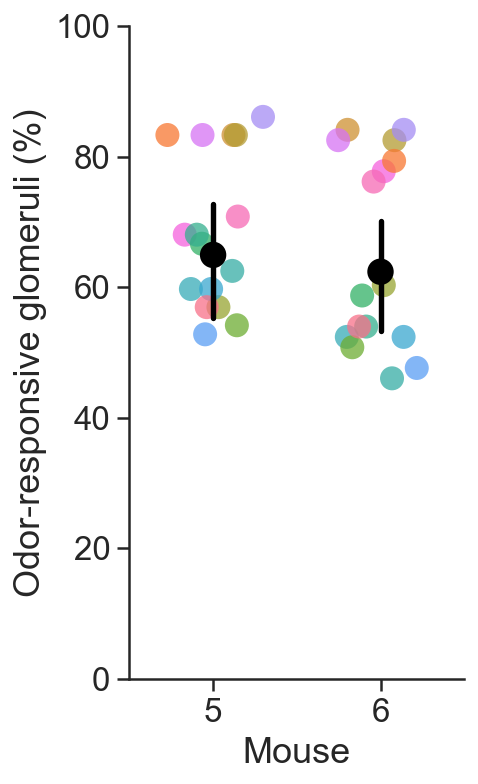

In [7]:
np.random.seed(123)
fig, ax = bulb_viz.plot_pct(
    df_resp.reset_index().melt(id_vars="index"), x="variable", y="value", hue="index"
)
ax.set_ylabel("Odor-responsive glomeruli (%)")

# identify env-sensitive glomeruli empirically via permutation testing

In [8]:
sig_dfs = imaging.env_glom(traces, env_mapping, x, ODORS, resp_dict)

Getting odor-glom pairs that differ across environments for mouse 5...


100%|███████████████████████████████████████████████████████| 99999/99999 [00:10<00:00, 9980.04it/s]


Getting odor-glom pairs that differ across environments for mouse 6...


100%|██████████████████████████████████████████████████████| 99999/99999 [00:06<00:00, 14719.44it/s]


In [9]:
FDR_THRESH = 0.01
emp_dfs = {}
for k, df in sig_dfs.items():
    df["sig"] = df.p_adj <= FDR_THRESH
    emp_dfs[k] = df.groupby("name").sig.mean() * 100

Text(0, 0.5, 'Env-sensitive glomeruli\n(% of responsive glomeruli)')

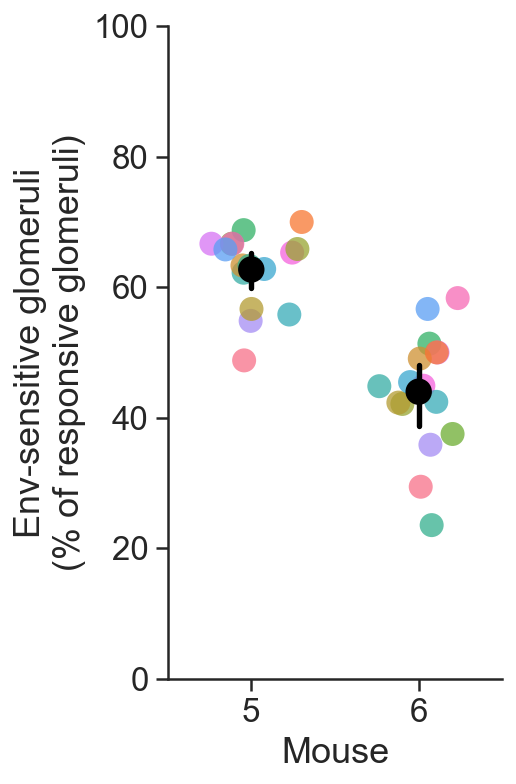

In [10]:
fig, ax = bulb_viz.plot_pct(pd.concat(emp_dfs).reset_index())
ax.set_ylabel("Env-sensitive glomeruli\n(% of responsive glomeruli)")

# get and plot correlation matrices

In [11]:
MOUSE_PLOT = "5"
corr_dfs = imaging.corr_mat(traces, env_mapping, x, ODORS, resp_dict)
corr_df = corr_dfs[MOUSE_PLOT]
# look at odor pairwise correlation in home-cage
corr_df['home-cage']['Pentanal'].sort_values(ascending=False)

Pentanal                    0.934525
Hexanal                     0.819645
Butanal                     0.665351
Pentanone                   0.585160
Hexanone                    0.578749
Ethyl acetate               0.520556
Butanone                    0.479471
Propyl acetate              0.475231
Heptanal                    0.446818
Trans-2-Methyl-2-butenal    0.441274
Benzaldehyde                0.339333
Butyl acetate               0.308522
Propanal                    0.281318
Methyl tiglate              0.184190
Methyl valerate             0.065958
Ethyl butyrate              0.020132
Name: Pentanal, dtype: float64

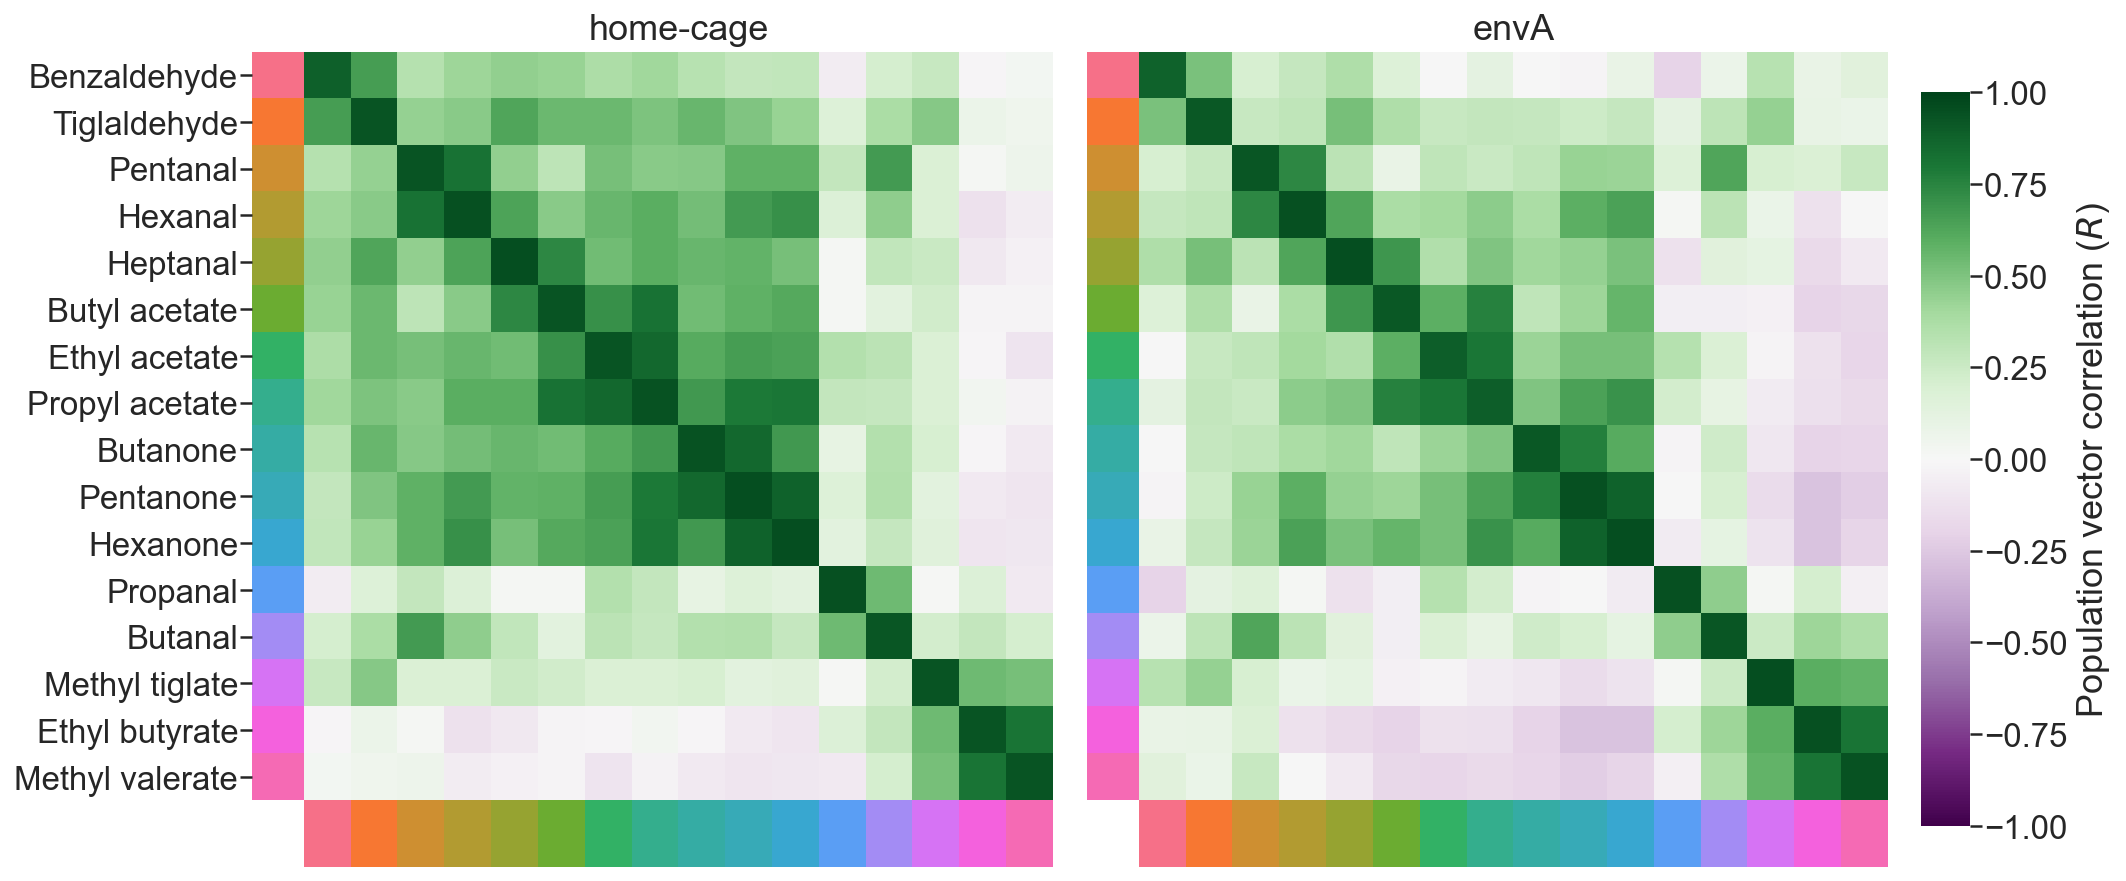

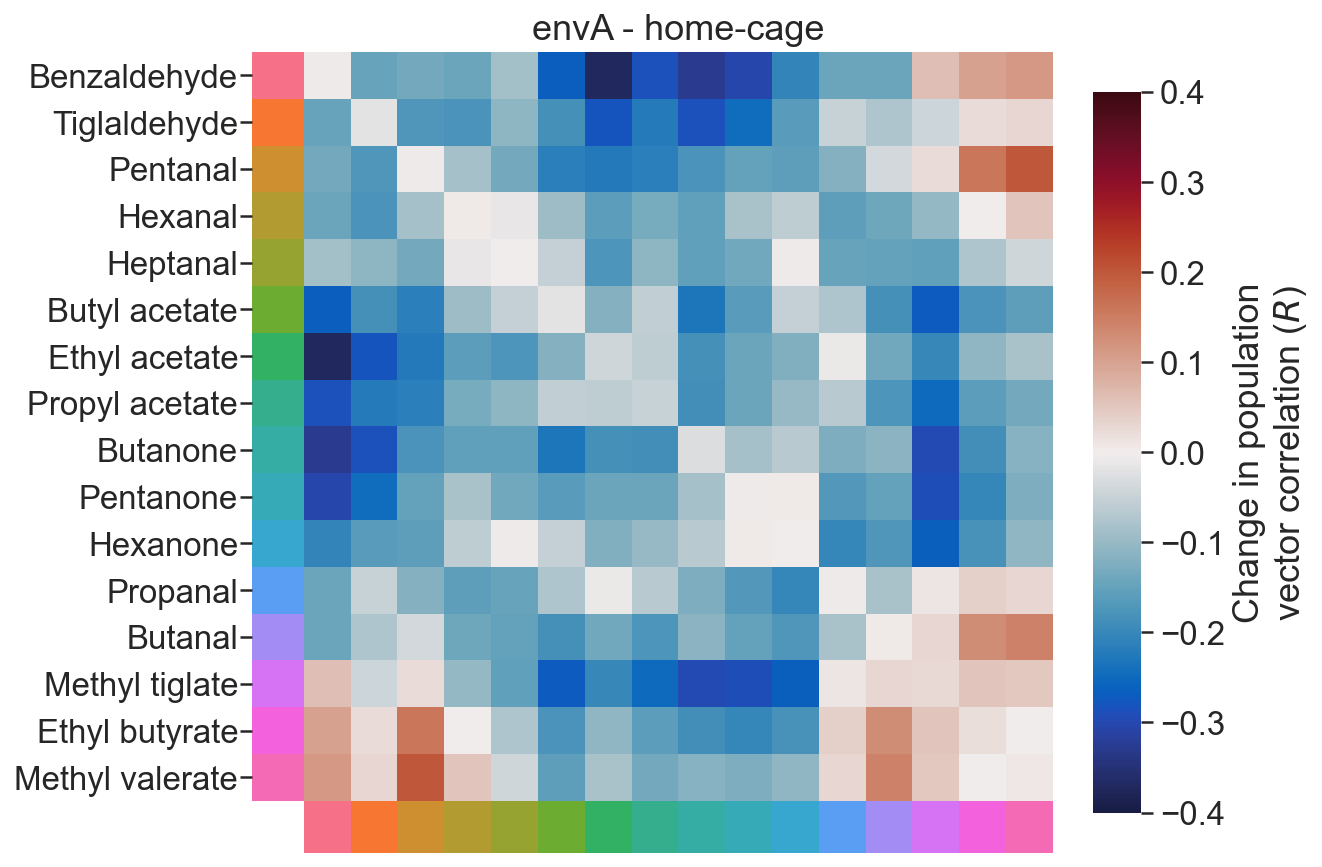

In [12]:
fig, odor_order = bulb_viz.plot_corr(corr_df);
delta_fig = bulb_viz.plot_delta(corr_df, odor_order);

# plot results of env decoding 
* Run the `env_decoding.py` script located in [../scripts/env_decoding.py](../scripts/env_decoding.py) to regenerate `env_results_fn`. See the options with `python env_decoding.py --help`

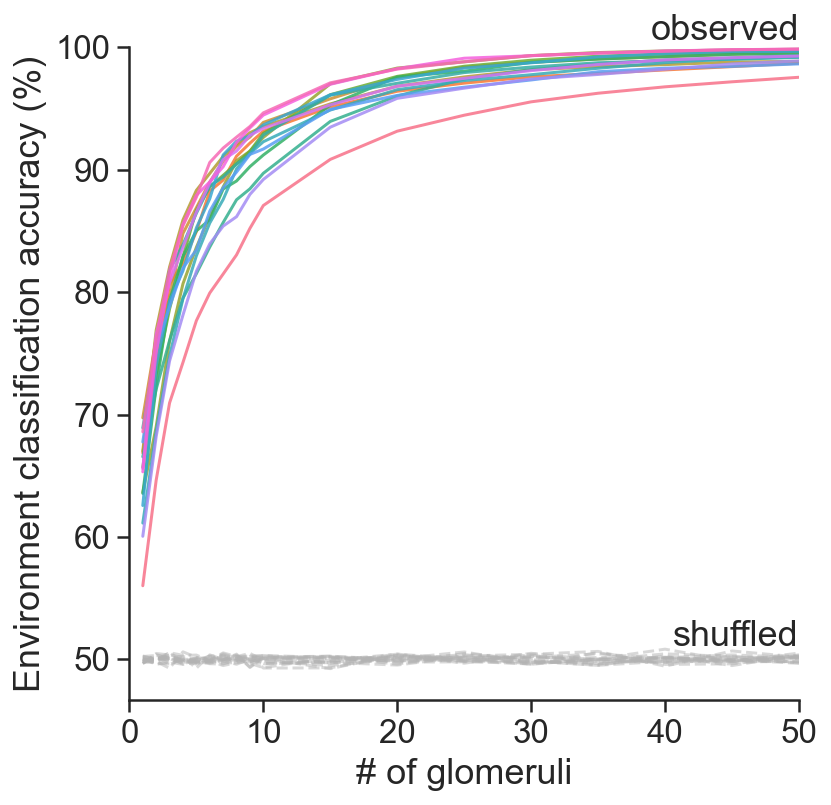

In [13]:
read_fn = lambda f: pd.read_csv(f, index_col=0)
data_fold = get_data_folders()
env_results_fn = data_fold.results / "Env_decoding_results.csv"
if env_results_fn.exists():
    df_env_decode = read_fn(env_results_fn)
    fig, ax = bulb_viz.plot_env_decoding(df_env_decode, odor_order)

# plot results of odor decoding 
* Run the `odor_decoding.py` script located in [../scripts/odor_decoding.py](../scripts/odor_decoding.py) to regenerate `obs_fn` and `shuff_fn` from the default and shuffled env (`-e`) conditions. For the full options see `python odor_decoding.py --help`

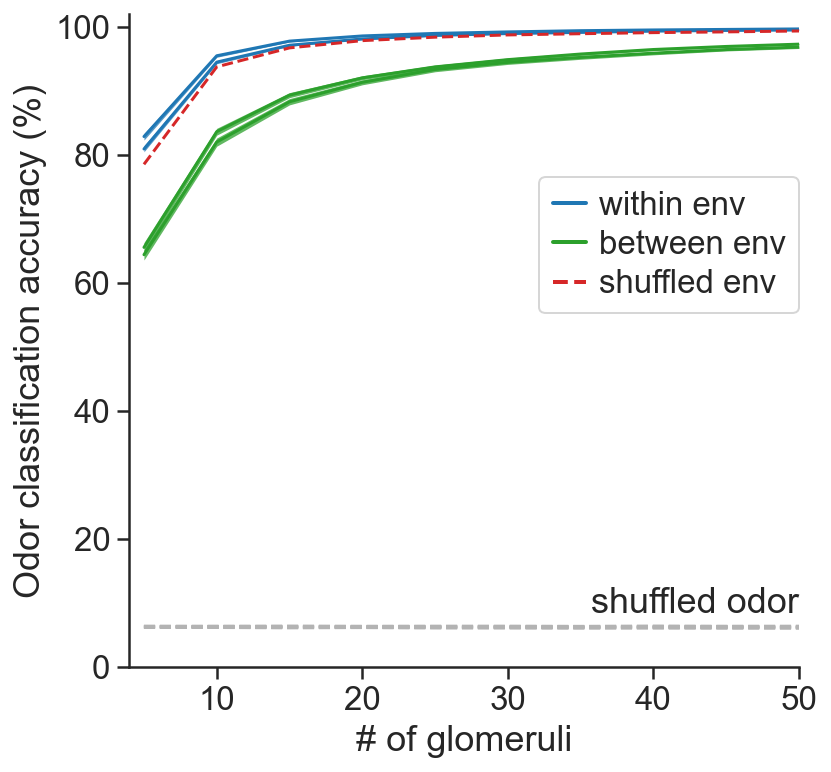

In [14]:
obs_fn = data_fold.results / "Odor_decoding_results_no_shuffle.csv"
shuff_fn = data_fold.results / "Odor_decoding_results_shuffled_env.csv"
if obs_fn.exists() and shuff_fn.exists():
    obs_melt = read_fn(obs_fn)
    shuff_melt = read_fn(shuff_fn)
    fig, ax = bulb_viz.plot_odor_decoding(obs_melt, shuff_melt)